In [ ]:
# Submission for Titanic data set

# First attempt at this or any other Kaggle data set

In [1]:
# packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
#from sklearn.preprocessing import LabelEncoder
import itertools
#from sklearn import ensemble, datasets
#from sklearn.ensemble import IsolationForest, AdaBoostClassifier, GradientBoostingClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#from sklearn.svm import LinearSVC, SVC
#from sklearn import svm, preprocessing


%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from scipy.stats import randint, uniform
from time import time
import random

from collections import defaultdict, Counter
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve


C:\Users\Russell\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## prep for training set

train = pd.read_csv('train.csv')

# impute median age into missing values
medAge = train.Age.median()

# replace NaN with medAge
train.Age = train.Age.fillna(medAge)

# change Sex and Embark variables to numeric / dummy
train.Sex.replace(('female', 'male'), (0,1), inplace=True)

# for now use the most frequent category for the missing points, but could consider using RF multiple imputation
train.Embarked.fillna(value='S', inplace=True)

# create dummies from the Embarked variable
dummies = pd.get_dummies(train.Embarked)
train = train.join(dummies)


In [3]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0


In [4]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'C', 'Q', 'S'],
      dtype='object')

In [5]:
train.set_index('PassengerId', inplace=True)
cols = [1,3,4,5,6,8,11,12,13] #numeric columns to use in xgb
features = list(train.columns[cols])

In [6]:
train[features].head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
PassengerId,,,,,,,,,
1,3,1,22.0,1,0,7.2500,0,0,1
2,1,0,38.0,1,0,71.2833,1,0,0


In [7]:
train[features].isnull().sum()

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
C         0
Q         0
S         0
dtype: int64

In [8]:
# helper functions for plotting (not mine)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score (", random_search.scoring ,") : {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")    
            
            
# function to calculate size of classes
def class_info(classes):
    counts = Counter(classes)
    total = sum(counts.values())
    for cls in counts.keys():
        print("%6s: % 7d  =  % 5.1f%%" % (cls, counts[cls], counts[cls]/total*100))


In [9]:
# separate in X, y

y = train.loc[:,train.columns == 'Survived']
y = np.ravel(y)  # flatten y into a 1-D array

X = train.loc[:, train.columns != 'Survived']

In [10]:
print("Initial class percentages:")
class_info(y)

Initial class percentages:
     0:     549  =   61.6%
     1:     342  =   38.4%


In [11]:
######################## Randomized grid search for tuning parameters of XGB ##############################

# create holdout
#seed = 666777
#test_size = 0.20
#X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=test_size, random_state=seed)

            
# instantiate the classifier            
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')

# weights on target class
#ratio = round(float(np.sum(y_train == 0)) / np.sum(y_train == 1),2)

# set the parameter to search over
param_dist = {'n_estimators': randint(300, 1000),
              'learning_rate': uniform(0.01, 0.07),
              'subsample': uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': uniform(0.5, 0.9),
              'min_child_weight': [3, 5, 7, 10, 12],
              'max_delta_step': [1, 5, 10, 15],
              #'scale_pos_weight': [ratio]
             }

start = time()

# run randomized search
n_iter_search = 20
folds = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(clf_xgb, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring = 'roc_auc', error_score = 0, verbose = 3, n_jobs = -1,
                                  cv=folds)

#random_search.fit(X_train, y_train)
random_search.fit(X[features], y)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# prediction on unseen data
#y_pred = random_search.predict(X_test)

# Compute confusion matrix
# survive_names = np.array(['Died', 'Survived'])
# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# plt.figure()
# plot1 = plot_confusion_matrix(cnf_matrix, classes=survive_names, title='Confusion matrix')
# plt.show()

# # AUC curve
# y_probas = random_search.predict_proba(X_test)# predicted results
# fpr, tpr, thresholds = roc_curve(y_test, y_probas[:,1], pos_label=1)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.2s finished


RandomizedSearchCV took 21.95 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score ( roc_auc ) : 0.883 (std: 0.020)
Parameters: {'colsample_bytree': 0.93897653918920976, 'learning_rate': 0.071903238619517001, 'max_delta_step': 10, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 431, 'subsample': 0.35289165845731019}

Model with rank: 2
Mean validation score ( roc_auc ) : 0.880 (std: 0.025)
Parameters: {'colsample_bytree': 0.70421675819955709, 'learning_rate': 0.064895048919424075, 'max_delta_step': 15, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.87048787142315409}

Model with rank: 3
Mean validation score ( roc_auc ) : 0.879 (std: 0.025)
Parameters: {'colsample_bytree': 0.94614299980533456, 'learning_rate': 0.029123471290330924, 'max_delta_step': 10, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 921, 'subsample': 0.70919622088297085}



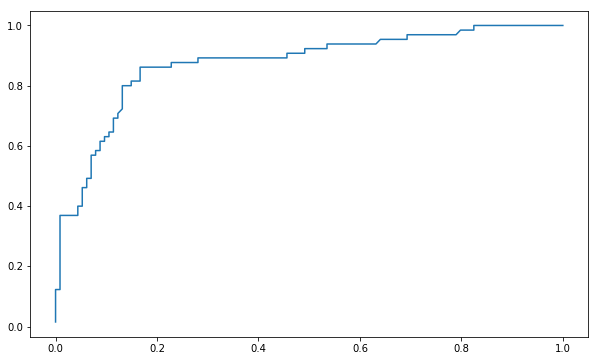

AUC: 0.87375168691


In [52]:
# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

#title="ROC Curve for xgb with CV and randomized search for optimal parameters"
# Print AUC
auc = np.trapz(tpr, fpr)
print('AUC:', auc)

In [12]:
## prep for test set

test = pd.read_csv('test.csv') # new data in same format as 'train.csv'

# change Sex and Embark variables to numeric / dummy
test.Sex.replace(('female', 'male'), (0,1), inplace=True)

# create dummies from the Embarked variable
dummies_test = pd.get_dummies(test.Embarked)
test = test.join(dummies_test)


In [13]:
test.set_index('PassengerId', inplace=True)

In [14]:
test[features].head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
PassengerId,,,,,,,,,
892,3,1,34.5,0,0,7.8292,0,1,0
893,3,0,47.0,1,0,7.0000,0,0,1


In [15]:
# run model on test set to give predictions
# prediction on unseen data
y_predictions = random_search.predict(test[features])

In [16]:
d = {'Survived': y_predictions}

In [17]:
index = test.index

In [18]:
gender_submission = pd.DataFrame(data=d, index=index)

In [19]:
gender_submission.head(2)

,Survived
PassengerId,
892,0
893,0


In [20]:
gender_submission.to_csv('gender_submission.csv')